In [1]:
import bt
import pandas

In [7]:
import dtale

In [2]:
class WeighTarget(bt.Algo):
    """
    Sets target weights based on a target weight DataFrame.

    Args:
        * target_weights (DataFrame): DataFrame containing the target weights

    Sets:
        * weights

    """

    def __init__(self, target_weights):
        self.tw = target_weights

    def __call__(self, target):
        # get target weights on date target.now
        if target.now in self.tw.index:
            w = self.tw.loc[target.now]

            # save in temp - this will be used by the weighing algo
            # also dropping any na's just in case they pop up
            target.temp['weights'] = w.dropna()

        # return True because we want to keep on moving down the stack
        return True

In [13]:
sma50

,spy
Date,
2010-01-04,NaN
2010-01-05,NaN
2010-01-06,NaN
2010-01-07,NaN
2010-01-08,NaN
...,...
2024-05-13,512.554923
2024-05-14,512.806659
2024-05-15,513.290079


In [14]:
sma200

,spy
Date,
2010-01-04,NaN
2010-01-05,NaN
2010-01-06,NaN
2010-01-07,NaN
2010-01-08,NaN
...,...
2024-05-13,468.829116
2024-05-14,469.185262
2024-05-15,469.569504


In [3]:
## download some data & calc SMAs
data = bt.get('spy', start='2010-01-01')
sma50 = data.rolling(50).mean()
sma200 = data.rolling(200).mean()

## now we need to calculate our target weight DataFrame
# first we will copy the sma200 DataFrame since our weights will have the same strucutre
tw = sma200.copy()
# set appropriate target weights
tw[sma50 > sma200] = 1.0
tw[sma50 <= sma200] = -1.0
# here we will set the weight to 0 - this is because the sma200 needs 200 data points before
# calculating its first point. Therefore, it will start with a bunch of nulls (NaNs).
tw[sma200.isnull()] = 0.0

[*********************100%%**********************]  1 of 1 completed


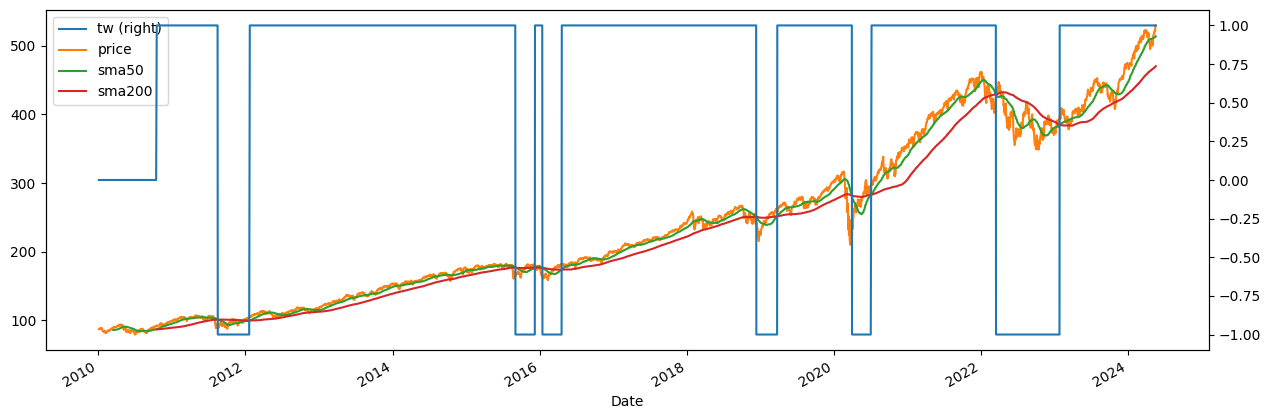

In [9]:
# plot the target weights + chart of price & SMAs
tmp = bt.merge(tw, data, sma50, sma200)
tmp.columns = ['tw', 'price', 'sma50', 'sma200']
ax = tmp.plot(figsize=(15,5), secondary_y=['tw'])

In [10]:
ma_cross = bt.Strategy('ma_cross', [WeighTarget(tw),
                                    bt.algos.Rebalance()])

t = bt.Backtest(ma_cross, data)
res = bt.run(t)

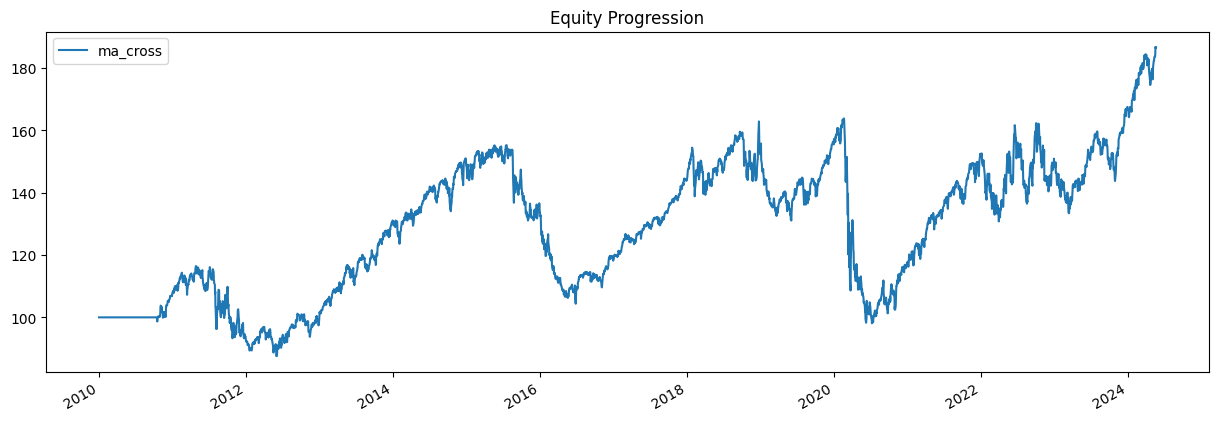

In [11]:
res.plot();

In [12]:
res.display()

Stat                 ma_cross
-------------------  ----------
Start                2010-01-03
End                  2024-05-17
Risk-free rate       0.00%

Total Return         86.66%
Daily Sharpe         0.35
Daily Sortino        0.52
CAGR                 4.44%
Max Drawdown         -40.12%
Calmar Ratio         0.11

MTD                  5.47%
3m                   6.32%
6m                   18.29%
YTD                  11.73%
1Y                   29.35%
3Y (ann.)            12.41%
5Y (ann.)            6.46%
10Y (ann.)           3.33%
Since Incep. (ann.)  4.44%

Daily Sharpe         0.35
Daily Sortino        0.52
Daily Mean (ann.)    5.73%
Daily Vol (ann.)     16.62%
Daily Skew           -0.59
Daily Kurt           12.34
Best Day             9.06%
Worst Day            -10.94%

Monthly Sharpe       0.37
Monthly Sortino      0.59
Monthly Mean (ann.)  5.43%
Monthly Vol (ann.)   14.56%
Monthly Skew         -0.60
Monthly Kurt         0.79
Best Month           10.87%
Worst Month          -12.49%
